# Sua primeira rede neural

Neste projeto, você construirá sua primeira rede neural e a utilizará para prever o número de usuários diários de aluguel de bicicletas. Fornecemos alguns códigos, mas deixamos a implementação da rede neural até você (na maior parte do tempo). Depois de enviar este projeto, sinta-se à vontade para explorar mais os dados e o modelo.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carregar e preparar os dados

Um passo crítico no trabalho com redes neurais é preparar os dados corretamente. Variáveis ​​em diferentes escalas dificultam que a rede aprenda com eficiência os pesos corretos. Abaixo, escrevemos o código para carregar e preparar os dados. Você aprenderá mais sobre isso em breve!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Verificando os dados

Este conjunto de dados tem o número de pilotos para cada hora de cada dia de 1 de janeiro de 2011 a 31 de dezembro de 2012. O número de pilotos é dividido entre casual e registrado, resumido na coluna `cnt`. Você pode ver as primeiras linhas dos dados acima.

Abaixo está um gráfico mostrando o número de ciclistas nos primeiros 10 dias ou mais no conjunto de dados. (Alguns dias não têm exatamente 24 entradas no conjunto de dados, portanto, não são exatamente 10 dias.) Você pode ver as locações por hora aqui. Esses dados são bem complicados! Os fins de semana são mais baixos em todos os passageiros e há picos quando as pessoas estão pedalando para ir e voltar do trabalho durante a semana. Olhando para os dados acima, também temos informações sobre temperatura, umidade e velocidade do vento, todas elas provavelmente afetando o número de passageiros. Você tentará capturar tudo isso com o seu modelo.

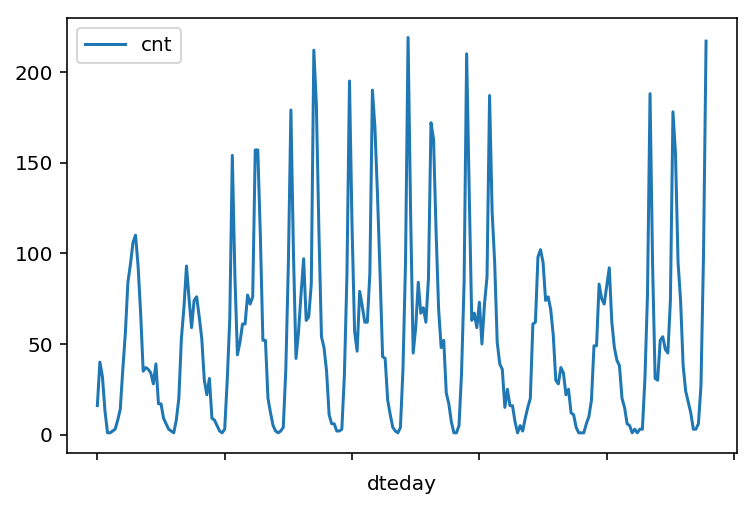

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variáveis Dummies
Aqui temos algumas variáveis  categóricas como estação, clima, mês. Para incluí-los em nosso modelo, precisaremos fazer variáveis dummy binárias. Isto é simples de fazer com os Pandas graças a `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Dimensionamento de variáveis de destino
Para facilitar o treinamento da rede, padronizaremos cada uma das variáveis contínuas. Ou seja, vamos mudar e dimensionar as variáveis de forma que elas tenham média zero e um desvio padrão de 1.

Os fatores de escala são salvos para que possamos retroceder quando usamos a rede para previsões.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Dividindo os dados em conjuntos de treinamento, teste e validação

Salvaremos os dados dos últimos 21 dias para usar como um conjunto de testes após termos treinado a rede. Usaremos esse conjunto para fazer previsões e compará-las com o número real de passageiros.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]


Vamos dividir os dados em dois conjuntos, um para treinamento e outro para validação conforme a rede estiver sendo treinada. Como são dados de séries temporais, vamos treinar dados históricos e tentar prever dados futuros (o conjunto de validação).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Hora de construir a rede

Abaixo você construirá sua rede. Nós construímos a estrutura. Você implementará o passe para frente e o para trás na rede. Você também definirá os hiperparâmetros: a taxa de aprendizado, o número de unidades ocultas e o número de passes de treinamento.

<img src="assets/neural_network.png" width=300px>

A rede tem duas camadas, uma camada oculta e uma camada de saída. A camada oculta usará a função sigmóide para ativações. A camada de saída tem apenas um nó e é usada para a regressão, a saída do nó é a mesma que a entrada do nó. Ou seja, a função de ativação é $ f (x) = x $. Uma função que recebe o sinal de entrada e gera um sinal de saída, mas leva em consideração o limite, é chamada de função de ativação. Trabalhamos através de cada camada de nossa rede, calculando as saídas para cada neurônio. Todas as saídas de uma camada se tornam entradas para os neurônios na próxima camada. Este processo é chamado * propagação direta *.

Usamos os pesos para propagar os sinais da entrada para as camadas de saída em uma rede neural. Usamos os pesos para também propagar o erro da saída de volta para a rede para atualizar nossos pesos. Isso é chamado de * backpropagation *.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [59]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [60]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Testes unitários

Execute estes testes unitários para verificar a exatidão de sua implementação de rede. Isso ajudará você a ter certeza de que sua rede foi implementada corretamente antes de começar a treiná-la. Todos estes testes devem ser bem sucedidos para passar o projeto.

In [61]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Treinando a rede

Aqui você configurará os hiperparâmetros para a rede. A estratégia aqui é encontrar hiperparâmetros de forma que o erro no conjunto de treinamento seja baixo, mas você não está super adaptando aos dados. Se você treinar a rede por muito tempo ou tiver muitos nós ocultos, ela poderá se tornar excessivamente específica para o conjunto de treinamento e falhará em generalizar para o conjunto de validação. Ou seja, a perda no conjunto de validação começará a aumentar à medida que a perda do conjunto de treinamento cair.

Você também usará um método conhecido como Descentramento Estocástico de Gradiente (SGD) para treinar a rede. A ideia é que, para cada passe de treinamento, você pegue uma amostra aleatória dos dados em vez de usar o conjunto de dados inteiro. Você usa muito mais passes de treinamento do que com descida de gradiente normal, mas cada passe é muito mais rápido. Isso acaba treinando a rede de forma mais eficiente. Você aprenderá mais sobre o SGD mais tarde.

### Escolha o número de iterações
Esse é o número de lotes de amostras dos dados de treinamento que usaremos para treinar a rede. Quanto mais iterações você usar, melhor o modelo se ajustará aos dados. No entanto, esse processo pode ter retornos bastante reduzidos e pode desperdiçar recursos computacionais se você usar muitas iterações. Você deseja encontrar um número aqui em que a rede tenha uma baixa perda de treinamento e a perda de validação seja mínima. O número ideal de iterações seria um nível que pára logo após a perda de validação não estar mais diminuindo.

### Escolha a taxa de aprendizado
Isso dimensiona o tamanho das atualizações de peso. Se isso for muito grande, os pesos tendem a explodir e a rede não consegue ajustar os dados. Normalmente, uma boa escolha para começar é 0,1; no entanto, se você dividir efetivamente a taxa de aprendizado por n_records, tente começar com uma taxa de aprendizado de 1. Em ambos os casos, se a rede tiver problemas para ajustar os dados, tente reduzir a taxa de aprendizado. Observe que quanto menor a taxa de aprendizado, menores são as etapas nas atualizações de peso e mais tempo leva para a rede neural convergir.

### Escolha o número de nós ocultos
Em um modelo em que todos os pesos são otimizados, quanto mais nós ocultos você tiver, mais precisas serão as previsões do modelo. (Um modelo totalmente otimizado poderia ter pesos de zero, afinal.) No entanto, quanto mais nós ocultos você tiver, mais difícil será otimizar os pesos do modelo, e mais provável será que os pesos abaixo do ideal levem a overfitting. Com overfitting, o modelo memorizará os dados de treinamento em vez de aprender o padrão verdadeiro e não generalizará bem os dados não vistos.

Tente alguns números diferentes e veja como isso afeta o desempenho. Você pode olhar o dicionário de perdas para uma métrica do desempenho da rede. Se o número de unidades ocultas for muito baixo, o modelo não terá espaço suficiente para aprender e, se estiver muito alto, haverá muitas opções para a direção que o aprendizado pode tomar. O truque aqui é encontrar o equilíbrio certo no número de unidades ocultas que você escolher. Geralmente, você descobrirá que o melhor número de nós ocultos a usar acaba sendo entre o número de nós de entrada e saída.

In [62]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 1.1% ... Training loss: 0.923 ... Validation loss: 1.611

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 99.8% ... Training loss: 0.289 ... Validation loss: 0.474

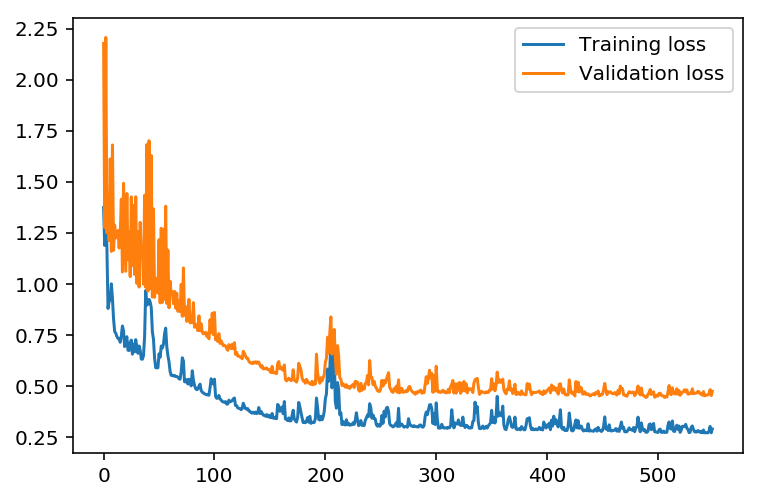

In [63]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Confira suas previsões

Aqui, use os dados de teste para ver como sua rede está modelando os dados. Se algo estiver completamente errado aqui, verifique se cada etapa da sua rede está implementada corretamente.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


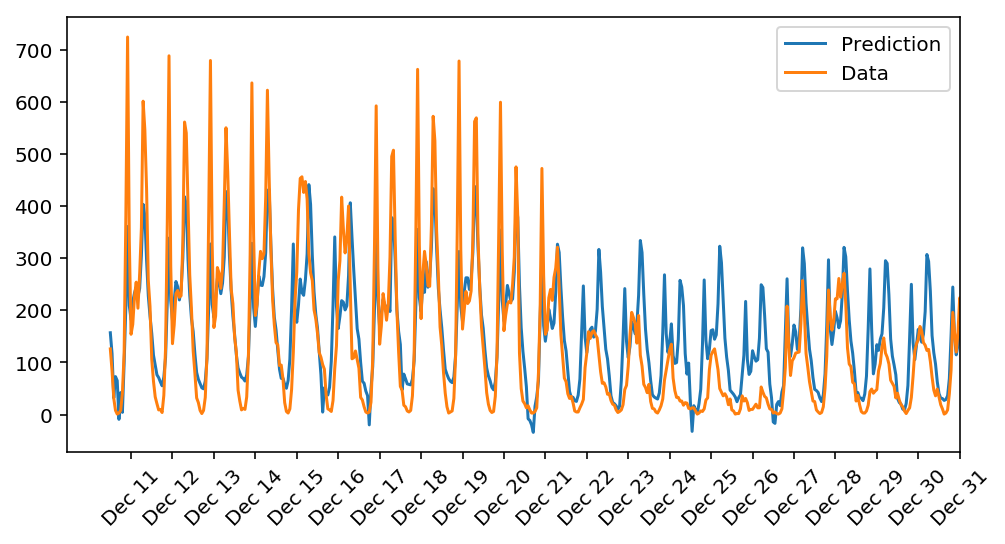

In [64]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

li que falha por que na epoca era uma epoca de natal, e falha pq as pessoas esqueceram de escrever os nomes na lista se na lista tivesse uma coluninha de dados especiais "feriadinhos coleguinhas" certamente melhoraria no processo de construção do modelo, enfim acho isso, dai creio que poderia fungar certinho <3
Where does it fail?


## FONTES de pesquisa 

- https://github.com/mhowto/first-neural-network
- https://www.tensorflow.org/tutorials/keras/basic_classification
- https://github.com/RomelTorres/DLND-first-neural-network/blob/master/Your_first_neural_network.ipynb
- https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- https://www.youtube.com/watch?v=9uS0qiMeZu0
- https://www.youtube.com/watch?v=vOppzHpvTiQ
